In [14]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import JSON

In [15]:
api_key = "REDACTED"

In [16]:
channel_ids = ["UCU4ZadLwXcQsZhdAMToxH_g"]

In [17]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_ids)
)
response = request.execute()

JSON(response)

<IPython.core.display.JSON object>

In [18]:
def get_stats(youtube, channel_ids):

    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
    )
    response = request.execute();

    #looooooop
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
               }

        all_data.append(data)

    return(pd.DataFrame(all_data))

In [19]:
channel_stats = get_stats(youtube, channel_ids)

In [20]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Jofré Martin - Classical Guitar,1150,235467,206,UUVriwe7B3oulIK6FA-amy0g


In [31]:
request = youtube.playlists().list(
    part="snippet,contentDetails",
    channelId="UCU4ZadLwXcQsZhdAMToxH_g",
    maxResults=25
)
response=request.execute()

JSON(response)

<IPython.core.display.JSON object>

In [41]:
playlist_id = "PL6VjWzvpT0r9MpI-gfg6wQ7ILIMfRz_6s"

def get_video_ids(youtube, playlist_id):
    video_ids=[]
    request=youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request=youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken = next_page_token)
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        next_page_token = response.get('nextPageToken')

    return video_ids

In [42]:
video_ids = get_video_ids(youtube,playlist_id)
len(video_ids)

54

In [43]:
def get_video_info(youtube,video_ids):

    all_video_info = []

    for i in range(0,len(video_ids),50):
        request = youtube.videos().list(
            part='snippet,contentDetails,statistics',
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        JSON(response)
        
        for video in response['items']:
            desired_stats = {'snippet': ['channelTitle','title','tags','publishedAt'],
                             'statistics': ['viewCount','likeCount','favoriteCount','commentCount'],
                             'contentDetails': ['duration']}
            video_info = {}
            video_info['video_id'] = video['id']
        
            for k in desired_stats.keys():
                for v in desired_stats[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
        
            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [44]:
videos_df = get_video_info(youtube,video_ids)

In [45]:
# data time

In [46]:
videos_df.dtypes

video_id         object
channelTitle     object
title            object
tags             object
publishedAt      object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
duration         object
dtype: object

In [47]:
numeric_columns = ['viewCount','likeCount','favoriteCount','commentCount']
videos_df[numeric_columns] = videos_df[numeric_columns].apply(pd.to_numeric, errors='coerce',axis=1)

In [48]:
# get composers & titles

videos_df = pd.DataFrame(videos_df[['title','viewCount','likeCount','commentCount']])
composers_df = pd.DataFrame
titles_df = pd.DataFrame
videos_df[['composer','title']] = videos_df['title'].str.split('-',n=1,expand=True)

# get composer info
videos_df[['composer_forename','composer_surname']] = videos_df['composer'].str.split(' ',n=1,expand=True)

videos_df.loc[videos_df['composer_surname'].apply(lambda x: pd.isna(x) or x == ''), 'composer_surname'] = videos_df['composer_forename']
videos_df.loc[videos_df['composer_surname'] == videos_df['composer_forename'], 'composer_forename'] = None

# if no composer
videos_df.loc[videos_df['title'].isna(), 'title'] = videos_df['composer']
videos_df.loc[videos_df['title'] == videos_df['composer'], ['composer','composer_surname','composer_forename']] = None

# remove parenthetical info
videos_df['title'] = videos_df['title'].str.split('(',n=1,expand=True)[0]

videos_df

,title,viewCount,likeCount,commentCount,composer,composer_forename,composer_surname
0,"Minuet in C Minor, Op. 24 No. 1",355,3,0,F. Sor,F.,Sor
1,"Minuet, D.334",518,22,3,Schubert,None,Schubert
2,The Lothian Lassie,291,5,0,None,None,None
3,"Andante Study, Op. 100 No. 42",1129,40,9,Ernest Shand,Ernest,Shand
4,"Allegretto Study, Op. 100 No. 44",1658,49,4,Ernest Shand,Ernest,Shand
5,Étude Andantino,874,17,0,Felix Horetzky,Felix,Horetzky
6,Schottische,1944,42,4,Pascual Roch,Pascual,Roch
7,Valse,2182,56,4,Pascual Roch,Pascual,Roch
8,Étude Moderato,715,28,4,Felix Horetzky,Felix,Horetzky
9,Adagio,1381,39,4,Felix Horetzky,Felix,Horetzky


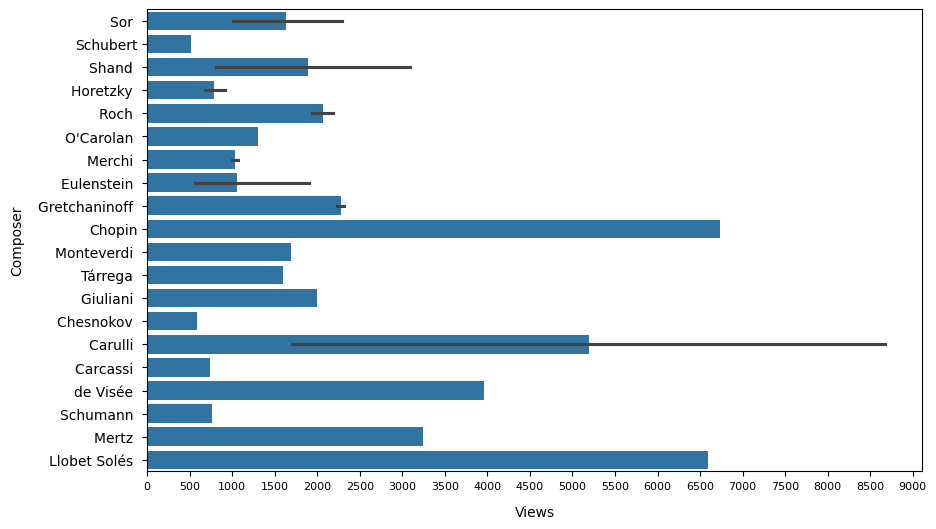

In [49]:
composer_data = pd.DataFrame(videos_df, columns=['title','composer_surname','viewCount'])

plt.figure(figsize=(10, 6))
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.xlabel('Views',labelpad=10)
plt.ylabel('Composer',labelpad=10)
plot = sns.barplot(composer_data,x='viewCount',y='composer_surname')
plot.xaxis.set_major_locator(ticker.MultipleLocator(500))